# Implementation of PCA-n2v for MSI datasets

In [1]:
%matplotlib inline
import pathlib
import shutil
import tqdm.auto as tqdm
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from tifffile import imread
from skimage.measure import block_reduce

In [2]:
from utils import load_data, tif_to_matrix
from model import compute_scores, denoise_scores, reconstruct, memory_alloc

2025-01-29 11:56:20.021022: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 11:56:20.071373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 11:56:20.071415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 11:56:20.073164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 11:56:20.082477: I tensorflow/core/platform/cpu_feature_guar

On a GPU with a large amount of memory Tensorflow will over-allocate, use the following to limit the allocation:

In [3]:
memory_alloc(n_gb=10)

Load data and prepare for training.

In [4]:
f_dir = pathlib.Path("./data")
model_name = "algae"
model_dir = f_dir / model_name
if True:  # delete past results
    shutil.rmtree(model_dir, ignore_errors=True)
    _ = [f.unlink() for f in f_dir.glob("*_components.npy")]
    _ = [f.unlink() for f in f_dir.glob("*_dn.npz")]
    _ = [f.unlink() for f in f_dir.glob("*_scores.npy")]
# The data are stored as a 2D sparse matrix, this shape corresponds to the true hyperspectral map shape
true_shape = (1024, 1024, 189)
data = load_data(
    f_dir / "Coela_Raw.npz"
)
assert np.prod(true_shape) == np.prod(data.shape), "Supplied shape does not match the data loaded from .npz"
# reconstruct the 3D map with the correct shape
data = data.reshape(true_shape)
print(data.shape)

(1024, 1024, 189)


## Note on file formats

Our data is stored as `.npz` files containing 2D `scipy.sparse` CSR arrays. We highly recommend it for MSI datasets which usually mostly comprise large regions where counts are zeros.

The file `utils.py` contains converters between `.tif` and sparse `.npz` data.

## Binning

So that the example notebook executes faster we bin the dataset to reduce its size. For best results skip this binning step.

In [5]:
data = block_reduce(data, (2, 2, 10))  # binning the data in the x, y and m/z dimensions simultaneously
print(data.shape)

(512, 512, 19)


## PCA-denoising

We are now ready to perform the PCA. The scores will be saved as `.npy` matrix of dimensions `(n_pixels, n_mz)`.

In [6]:
print("Computing scores...")
scores = compute_scores(
    data,
    f_dir,
    d_name=model_name,
    save=True
).astype(np.float32)
scores = scores.reshape(data.shape)
print(scores.shape)

Computing scores...
(512, 512, 19)


We are now ready to train!

The function `denoise_scores` will be processing each of the score images independently and saving the denoised result and train history in the models folder.

The parameters are the following:
- `patch_shape`: set to `(64,64)` and `(16,16,16)` respectively for 2D and 3D images. You can change this shape, especially if the `x`, `y` and `z` dimensions are not equivalent spatially (case of layered materials for instance) but the numbers must remain divisible by 8.
- `batch_size`: We recommend adapting this to the capabilities of your GPU for best performance.
- `train_epochs`: Set here to 5 for faster execution, but should be of at least 100 for the training and validation losses to converge.
- `split_val`: ratio between validation and training patches.

To limit the output of the cell, only the detailed training log of the first score image is shown.

In [7]:
for score_idx in tqdm.trange(scores.shape[-1], desc="Denoising score"):
    denoise_scores(
        score_idx,
        scores[..., score_idx],
        patch_shape=(64,64),
        batch_size=128,
        basedir=f_dir,
        model_name=model_name,
        train_epochs=5,
        split_val=0.9,
        hide_output=score_idx > 0,
    )

Denoising score:   0%|          | 0/19 [00:00<?, ?it/s]

Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/nobackup/mb265392/.pyenv/versions/denoising/lib/python3.11/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /home/share_kiev-aar/200-Science_et_Technique/200.4-PFNC-DATA/mb265392/PCA-n2v/data/algae
  warnings.warn(
2025-01-29 11:56:25.815751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 410/410 [00:00<00:00, 3229.85it/s]


Epoch 1/5


2025-01-29 11:56:29.426141: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-01-29 11:56:32.003181: I external/local_xla/xla/service/service.cc:168] XLA service 0x7979268b2ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-29 11:56:32.003210: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-01-29 11:56:32.007599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738148192.120118  252593 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - 15s 166ms/step - loss: 0.6235 - n2v_mse: 0.6235 - n2v_abs: 0.5386 - val_loss: 0.5762 - val_n2v_mse: 0.5770 - val_n2v_abs: 0.6033 - lr: 4.0000e-04
Epoch 2/5
28/28 [==============================] - 2s 84ms/step - loss: 0.1307 - n2v_mse: 0.1307 - n2v_abs: 0.2751 - val_loss: 0.5445 - val_n2v_mse: 0.5450 - val_n2v_abs: 0.5890 - lr: 4.0000e-04
Epoch 3/5
28/28 [==============================] - 2s 85ms/step - loss: 0.1067 - n2v_mse: 0.1067 - n2v_abs: 0.2482 - val_loss: 0.5150 - val_n2v_mse: 0.5154 - val_n2v_abs: 0.5703 - lr: 4.0000e-04
Epoch 4/5
28/28 [==============================] - 2s 76ms/step - loss: 0.1012 - n2v_mse: 0.1012 - n2v_abs: 0.2393 - val_loss: 0.4394 - val_n2v_mse: 0.4398 - val_n2v_abs: 0.5284 - lr: 4.0000e-04
Epoch 5/5
28/28 [==============================] - 2s 66ms/step - loss: 0.0964 - n2v_mse: 0.0964 - n2v_abs: 0.2350 - val_loss: 0.3796 - val_n2v_mse: 0.3799 - val_n2v_abs: 0.4933 - lr: 4.0000e-04

Loading network weights from 'we

## Reconstruction

We can now reconstruct the denoised data. We recommend saving it as a sparse `.npz` matrix which is less demanding in term of memory.

Helper functions to transform `.tif` images to `.npz` matrixes are available.

In [8]:
tif_to_matrix(model_dir / "denoised_scores").shape

(262144, 19)

In [9]:
f_components = f_dir / f"{model_name}_components.npy"
print("Reconstructing data...")
data_dn = reconstruct(
    data,
    model_dir / "denoised_scores",
    f_components,
)
sparse.save_npz(
    f_dir / f"{model_name}_dn.npz",
    sparse.csr_matrix(data_dn.astype(np.float32)),
)

Reconstructing data...


We will now inspect the first score. Better results are expected when the training is longer. In this example it was set to 5 epochs only to achieve a shorter training time.

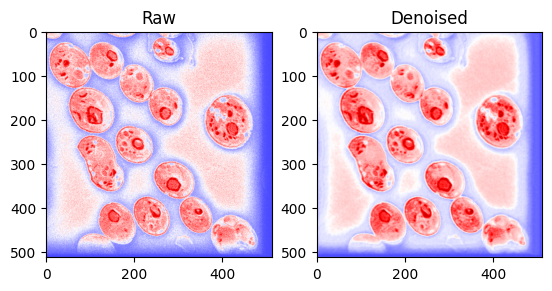

In [10]:
score_0_dn = imread(
    model_dir / "denoised_scores" / "score_0000.tiff"
)

fig, (ax1, ax2) = plt.subplots(1, 2)
nmax = np.max(np.abs(scores[..., 0]))
ax1.imshow(scores[..., 0], vmin=-nmax, vmax=nmax, cmap="seismic")
ax1.set_title("Raw")
nmax = np.max(np.abs(score_0_dn))
ax2.imshow(score_0_dn, vmin=-nmax, vmax=nmax, cmap="seismic")
ax2.set_title("Denoised");

We can also verify the convergence of the training and validation data:

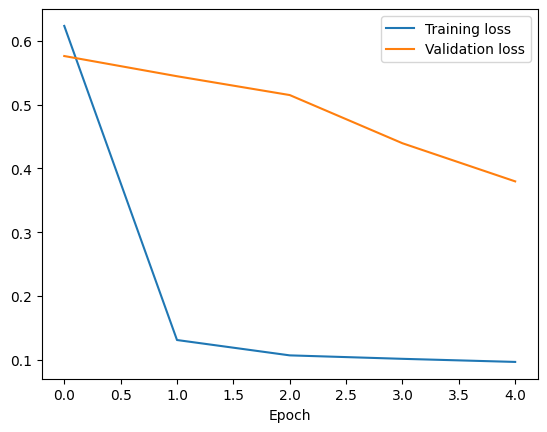

In [11]:
history_0 = pd.read_csv(
    model_dir / "history" / "history_0000.csv"
)

fig, ax = plt.subplots()
ax.plot(history_0["loss"], label="Training loss")
ax.plot(history_0["val_loss"], label="Validation loss")
ax.legend()
ax.set_xlabel("Epoch");

In a real denoising training, you should wait until the validation and training losses stabilize to achieve good results.

Let's now take a look at one of the denoised images from the reconstructed dataset.

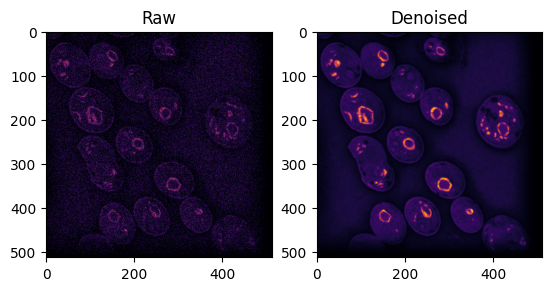

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[..., 1], cmap="inferno")
ax1.set_title("Raw")
ax2.imshow(data_dn.reshape(data.shape)[..., 1], cmap="inferno")
ax2.set_title("Denoised");